In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Union, Tuple
import math
import seaborn as sns

# Set the seaborn style - options include 'whitegrid', 'darkgrid', 'white', 'dark', 'ticks'
sns.set_theme(style='whitegrid') 
sns.color_palette("hls", 8)

# Set the context - options include 'paper', 'notebook', 'talk', 'poster'
sns.set_context("notebook", font_scale=1.2)  # Slightly larger text for better readability

# Set a custom color palette (optional)
custom_palette = sns.color_palette("Set2")
sns.set_palette(custom_palette)

# For matplotlib, you can also set a style
plt.style.use('seaborn-v0_8-whitegrid')  # Use a Seaborn style in matplotlib

In [3]:
class CategoricalFeatureTokenizer(nn.Module):
    """Embeds categorical features using embedding layers."""
    def __init__(self, cardinality: int, embed_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(cardinality, embed_dim)
        self.cardinality = cardinality
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get embeddings
        embedded = self.embedding(x.long())
        
        # Add a dimension to match the expected shape [batch_size, 1, embed_dim]
        embedded = embedded.unsqueeze(1)
        
        return embedded

class NumericalFeatureTokenizer(nn.Module):
    """Projects numerical features to a higher dimension."""
    def __init__(self, in_dim: int, embed_dim: int):
        super().__init__()
        self.projection = nn.Linear(in_dim, embed_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Ensure x is float
        x = x.float()
        
        # Project the numerical features
        output = self.projection(x)
        
        # Reshape to [batch_size, 1, embed_dim] to match CLS token shape
        output = output.unsqueeze(1)
        
        return output

In [4]:
class MultiHeadAttention(nn.Module):
    """Multi-head attention module."""
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.dense = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def split_heads(self, x: torch.Tensor, batch_size: int) -> torch.Tensor:
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size = q.size(0)
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled dot-product attention
        matmul_qk = torch.matmul(q, k.transpose(-1, -2))
        dk = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)
        
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
            
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, v)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(batch_size, -1, self.d_model)
        
        return self.dense(output)

class PositionWiseFeedForward(nn.Module):
    """Position-wise feed-forward network."""
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    """Transformer encoder layer."""
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
        
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed forward network with residual connection and layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

class FTTransformer(nn.Module):
    """Feature Tokenizer Transformer for tabular data."""
    def __init__(
        self,
        num_numerical_features: int,
        categorical_features_info: Dict[str, int],
        d_token: int = 64,
        num_transformer_blocks: int = 8,
        num_attention_heads: int = 8,
        d_ffn_factor: float = 4/3,
        attention_dropout: float = 0.2,
        ffn_dropout: float = 0.1,
        residual_dropout: float = 0.0,
        num_classes: int = 2,
        output_activation: Optional[str] = None
    ):
        super().__init__()
        
        self.num_classes = num_classes
        self.d_token = d_token
        
        # Feature tokenizers for numerical features
        self.numerical_tokenizer = (
            NumericalFeatureTokenizer(num_numerical_features, d_token)
            if num_numerical_features > 0 else None
        )
        
        # Feature tokenizers for categorical features
        self.categorical_tokenizers = nn.ModuleDict()
        for feature_name, cardinality in categorical_features_info.items():
            self.categorical_tokenizers[feature_name] = CategoricalFeatureTokenizer(cardinality, d_token)
        
        # CLS token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_token))
        
        # Transformer encoder blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderLayer(
                d_model=d_token,
                num_heads=num_attention_heads,
                d_ff=int(d_token * d_ffn_factor),
                dropout=attention_dropout
            )
            for _ in range(num_transformer_blocks)
        ])
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_token)
        
        # Output head
        self.output_head = nn.Linear(d_token, num_classes)
        
        # Output activation
        self.output_activation = None
        if output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation == 'softmax':
            self.output_activation = nn.Softmax(dim=1)
        
    def forward(
        self,
        numerical_features: Optional[torch.Tensor] = None,
        categorical_features: Optional[Dict[str, torch.Tensor]] = None
    ) -> torch.Tensor:
        # Initial embedding list with the CLS token
        batch_size = (
            numerical_features.size(0) if numerical_features is not None
            else next(iter(categorical_features.values())).size(0)
        )
        tokens = [self.cls_token.expand(batch_size, -1, -1)]
        
        # Process numerical features
        if numerical_features is not None and self.numerical_tokenizer is not None:
            numerical_tokens = self.numerical_tokenizer(numerical_features)
            tokens.append(numerical_tokens)
        
        # Process categorical features
        if categorical_features is not None:
            for feature_name, feature_values in categorical_features.items():
                if feature_name in self.categorical_tokenizers:
                    categorical_token = self.categorical_tokenizers[feature_name](feature_values)
                    tokens.append(categorical_token)
        
        # Combine all tokens
        x = torch.cat(tokens, dim=1)
        
        # Apply transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
            
        # Extract the CLS token representation
        cls_representation = x[:, 0]
        
        # Apply layer normalization
        cls_representation = self.layer_norm(cls_representation)
        
        # Apply output head
        logits = self.output_head(cls_representation)
        
        # Apply output activation if specified
        if self.output_activation is not None:
            logits = self.output_activation(logits)
            
        return logits

In [5]:
# Load the preprocessed dataset
data = pd.read_csv('../data/airline_passenger_satisfaction.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (25893, 32)


,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,satisfaction_encoded,Gender_encode,Customer_Type_encode,Travel_Type_encode,Class_Eco,Class_Business,Class_Eco_Plus
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,50,44.0,satisfied,1,0,1,1,1,0,0
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,0,0.0,satisfied,1,0,1,1,0,1,0
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,0,0.0,neutral or dissatisfied,0,1,0,1,1,0,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,0,6.0,satisfied,1,1,1,1,0,1,0
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,0,20.0,satisfied,1,0,1,1,1,0,0


In [6]:
class TabularDataset(Dataset):
    def __init__(self, numerical_features, categorical_features, targets=None):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.targets = targets
        
    def __len__(self):
        return len(next(iter(self.categorical_features.values())))
    
    def __getitem__(self, idx):
        numerical = self.numerical_features[idx] if self.numerical_features is not None else None
        categorical = {name: values[idx] for name, values in self.categorical_features.items()}
        
        if self.targets is not None:
            return numerical, categorical, self.targets[idx]
        return numerical, categorical

In [7]:
# Identify numerical and categorical features
# Check for available hardware acceleration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for acceleration")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for acceleration (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("No GPU acceleration available, using CPU")

# Display additional device information
if device.type == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
elif device.type == "mps":
    print("Using Apple Metal Performance Shaders")
else:
    print(f"Number of CPU threads: {torch.get_num_threads()}")

Using MPS device for acceleration (Apple Silicon)
Using Apple Metal Performance Shaders


In [8]:
# Identify columns
numerical_cols = [col for col in data.columns 
                 if col not in ['satisfaction', 'satisfaction_encoded', 'Gender', 'Customer Type', 
                               'Type of Travel', 'Class', 'Gender_encode', 'Customer_Type_encode', 
                               'Travel_Type_encode', 'Class_Eco', 'Class_Business', 'Class_Eco_Plus', 
                               'id', 'index']]

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"First few numerical columns: {numerical_cols[:5]}")

# Verify id and index are not included
if 'id' in numerical_cols or 'index' in numerical_cols:
    print("WARNING: id or index columns are included in the numerical features!")
else:
    print("Confirmed: id and index are not used for training")

# Define categorical features with the encoded versions
categorical_features = {
    'Gender': data['Gender_encode'].values,
    'CustomerType': data['Customer_Type_encode'].values, 
    'TravelType': data['Travel_Type_encode'].values,
    'Class': data['Class_Eco'].astype(int) * 0 + data['Class_Business'].astype(int) * 1 + data['Class_Eco_Plus'].astype(int) * 2
}

# Get target variable
y = data['satisfaction_encoded'].values

# Define cardinality for each categorical feature
categorical_cardinality = {
    'Gender': 2,  # Binary encoding (0/1)
    'CustomerType': 2,  # Binary encoding (0/1)
    'TravelType': 2,  # Binary encoding (0/1)
    'Class': 3  # 0=Eco, 1=Business, 2=Eco Plus
}

# Get numerical features
X_numerical = data[numerical_cols].values

# Train-test split
X_num_train, X_num_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)

# Split categorical features
cat_train = {}
cat_test = {}
train_indices, test_indices = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

for name, values in categorical_features.items():
    # Convert to numpy array before indexing
    values_np = np.array(values)
    cat_train[name] = values_np[train_indices]
    cat_test[name] = values_np[test_indices]



Number of numerical features: 18
First few numerical columns: ['Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking']
Confirmed: id and index are not used for training


In [9]:
# Scale numerical features
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Create datasets
train_dataset = TabularDataset(
    torch.FloatTensor(X_num_train), 
    {name: torch.LongTensor(values) for name, values in cat_train.items()}, 
    torch.LongTensor(y_train)
)

test_dataset = TabularDataset(
    torch.FloatTensor(X_num_test), 
    {name: torch.LongTensor(values) for name, values in cat_test.items()}, 
    torch.LongTensor(y_test)
)

# Create dataloaders
batch_size = 128  # Can be adjusted based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
num_numerical_features = X_num_train.shape[1]
print(f"Number of numerical features: {num_numerical_features}")

model = FTTransformer(
    num_numerical_features=num_numerical_features,
    categorical_features_info=categorical_cardinality,
    d_token=64,  # Embedding dimension
    num_transformer_blocks=3,  # Smaller for faster training
    num_attention_heads=8,
    d_ffn_factor=4/3,
    attention_dropout=0.2,
    ffn_dropout=0.1,
    num_classes=2  # Binary classification
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (numerical, categorical, targets) in enumerate(loader):
        # Move data to device
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(numerical_features=numerical, categorical_features=categorical)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        # Print progress every 20 batches
        if batch_idx % 20 == 0:
            print(f'Batch: {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for numerical, categorical, targets in loader:
            # Move data to device
            numerical = numerical.to(device)
            categorical = {name: values.to(device) for name, values in categorical.items()}
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(numerical_features=numerical, categorical_features=categorical)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_preds)
    
    return epoch_loss, epoch_acc, f1, auc

# Training loop
num_epochs = 15
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_auc': []
}

best_val_acc = 0
best_model_state = None

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validation
    val_loss, val_acc, val_f1, val_auc = evaluate(model, test_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with accuracy: {val_acc:.4f}")
    
    # Print epoch results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
    print()

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")





Number of numerical features: 18
Model has 85,889 trainable parameters


/opt/anaconda3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
------------------------------
Batch: 0/162, Loss: 0.9704, Acc: 44.53%
Batch: 20/162, Loss: 0.5087, Acc: 68.34%
Batch: 40/162, Loss: 0.3460, Acc: 77.04%
Batch: 60/162, Loss: 0.3660, Acc: 80.64%
Batch: 80/162, Loss: 0.4069, Acc: 82.83%
Batch: 100/162, Loss: 0.2507, Acc: 83.77%
Batch: 120/162, Loss: 0.2393, Acc: 84.72%
Batch: 140/162, Loss: 0.2225, Acc: 85.57%
Batch: 160/162, Loss: 0.2059, Acc: 86.33%
New best model saved with accuracy: 0.9201
Train Loss: 0.3248, Train Acc: 0.8632
Val Loss: 0.2167, Val Acc: 0.9201, Val F1: 0.9076, Val AUC: 0.9167

Epoch 2/15
------------------------------
Batch: 0/162, Loss: 0.2823, Acc: 89.84%
Batch: 20/162, Loss: 0.1883, Acc: 91.03%
Batch: 40/162, Loss: 0.1831, Acc: 91.20%
Batch: 60/162, Loss: 0.3321, Acc: 91.29%
Batch: 80/162, Loss: 0.2267, Acc: 91.58%
Batch: 100/162, Loss: 0.1741, Acc: 91.55%
Batch: 120/162, Loss: 0.2690, Acc: 91.63%
Batch: 140/162, Loss: 0.1768, Acc: 91.57%
Batch: 160/162, Loss: 0.2051, Acc: 91.66%
New best model saved wi

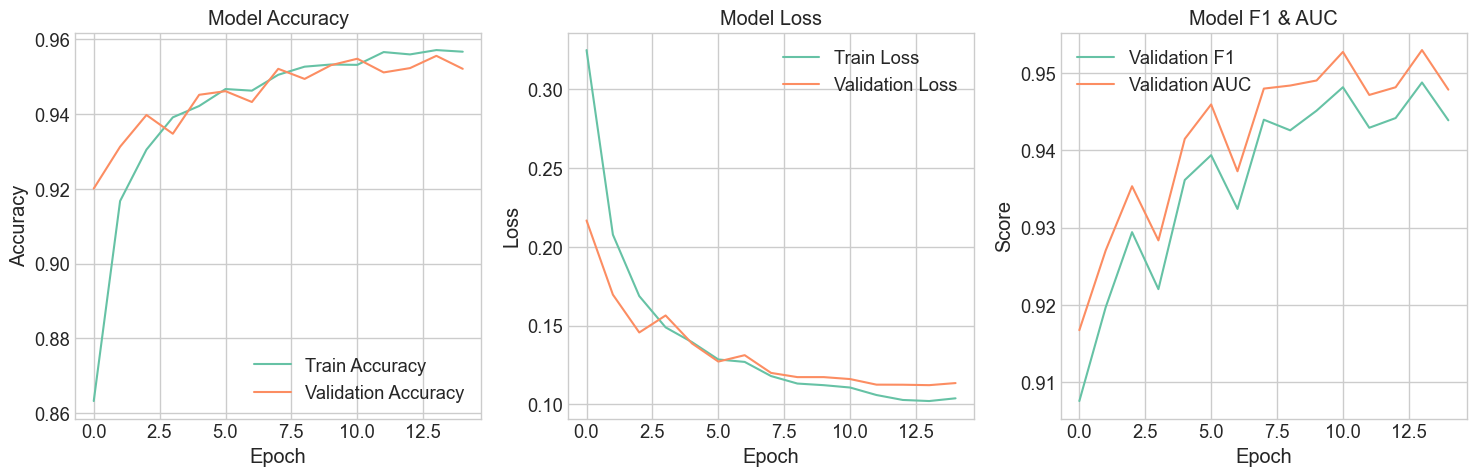


Final Test Results:
Accuracy: 0.9521
F1 Score: 0.9439
AUC: 0.9478


In [10]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot F1 and AUC
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1')
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Model F1 & AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation on test set
test_loss, test_acc, test_f1, test_auc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")

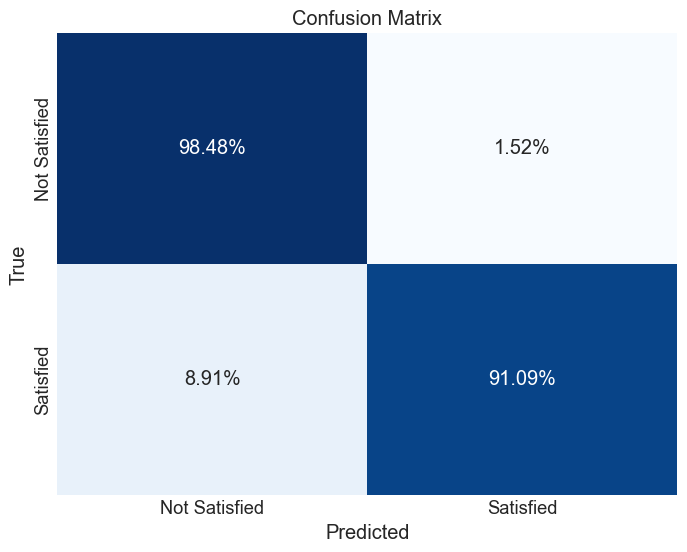

In [16]:
# plot a confusion matrix with percentages
from sklearn.metrics import confusion_matrix

# Get predictions
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for numerical, categorical, targets in test_loader:
        numerical = numerical.to(device)
        categorical = {name: values.to(device) for name, values in categorical.items()}
        targets = targets.to(device)
        
        outputs = model(numerical_features=numerical, categorical_features=categorical)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
# Convert to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=['Not Satisfied', 'Satisfied'],
            yticklabels=['Not Satisfied', 'Satisfied'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




Analyzing feature importance...


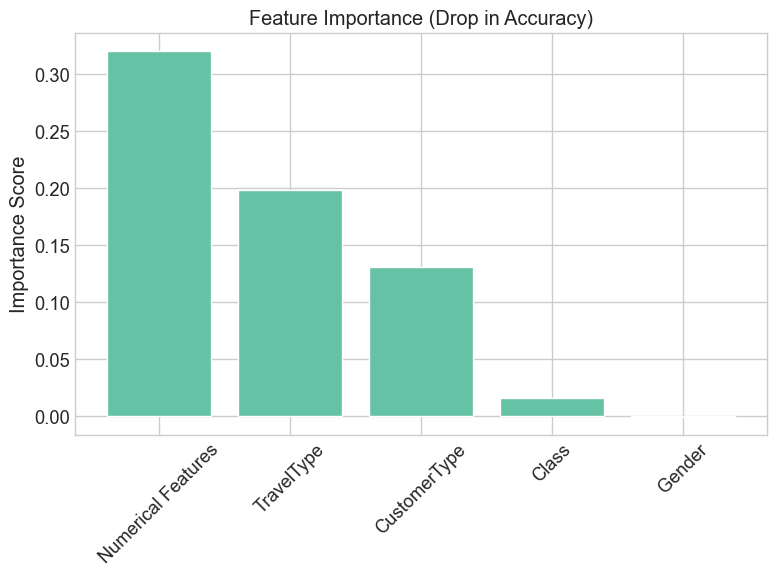


Feature Importance:
Numerical Features: 0.3201
TravelType: 0.1977
CustomerType: 0.1307
Class: 0.0160
Gender: -0.0006


In [11]:
# Feature importance analysis (simplified)
def analyze_feature_importance():
    # For categorical features
    importance = {}
    
    # Get baseline performance
    baseline_loss, baseline_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    # For each categorical feature
    for feature_name in categorical_cardinality.keys():
        # Create modified test dataset with random values for this feature
        modified_cat_test = cat_test.copy()
        modified_cat_test[feature_name] = np.random.randint(
            0, categorical_cardinality[feature_name], size=len(modified_cat_test[feature_name])
        )
        
        modified_dataset = TabularDataset(
            torch.FloatTensor(X_num_test),
            {name: torch.LongTensor(values) for name, values in modified_cat_test.items()},
            torch.LongTensor(y_test)
        )
        modified_loader = DataLoader(modified_dataset, batch_size=batch_size)
        
        # Evaluate with modified feature
        _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)
        
        # Importance = drop in accuracy
        importance[feature_name] = baseline_acc - modified_acc
    
    # For numerical features (as a group)
    # Shuffle numerical features
    modified_X_num = X_num_test.copy()
    np.random.shuffle(modified_X_num)
    
    modified_dataset = TabularDataset(
        torch.FloatTensor(modified_X_num),
        {name: torch.LongTensor(values) for name, values in cat_test.items()},
        torch.LongTensor(y_test)
    )
    modified_loader = DataLoader(modified_dataset, batch_size=batch_size)
    
    # Evaluate
    _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)
    importance['Numerical Features'] = baseline_acc - modified_acc
    
    return importance

# Analyze feature importance
print("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance()
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(sorted_importance.keys(), sorted_importance.values())
plt.title('Feature Importance (Drop in Accuracy)')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
for feature, score in sorted_importance.items():
    print(f"{feature}: {score:.4f}")


Analyzing feature importance...


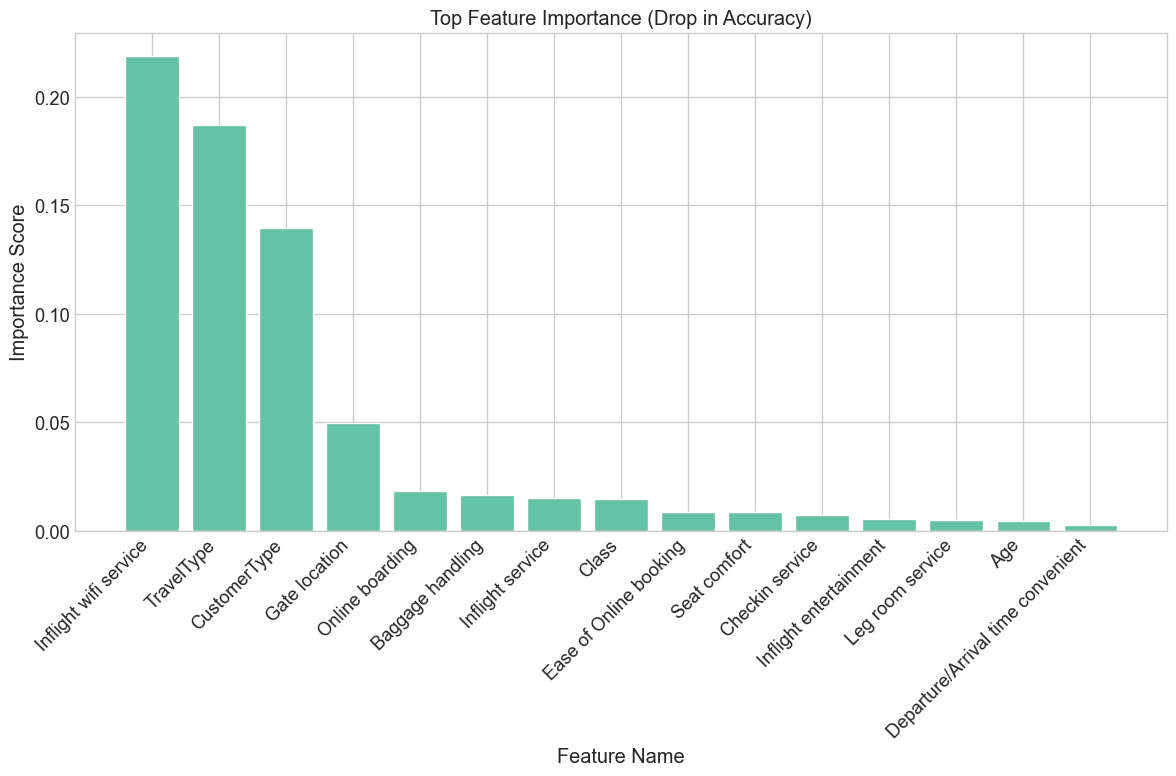


Feature Importance (Top 10):
1. Inflight wifi service: 0.2188
2. TravelType: 0.1871
3. CustomerType: 0.1398
4. Gate location: 0.0496
5. Online boarding: 0.0185
6. Baggage handling: 0.0164
7. Inflight service: 0.0153
8. Class: 0.0145
9. Ease of Online booking: 0.0085
10. Seat comfort: 0.0085


In [12]:
# Enhanced feature importance analysis showing individual numerical features
def analyze_feature_importance():
    # For categorical features
    importance = {}
    
    # Get baseline performance
    baseline_loss, baseline_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    # For each categorical feature
    for feature_name in categorical_cardinality.keys():
        # Create modified test dataset with random values for this feature
        modified_cat_test = cat_test.copy()
        modified_cat_test[feature_name] = np.random.randint(
            0, categorical_cardinality[feature_name], size=len(modified_cat_test[feature_name])
        )
        
        modified_dataset = TabularDataset(
            torch.FloatTensor(X_num_test),
            {name: torch.LongTensor(values) for name, values in modified_cat_test.items()},
            torch.LongTensor(y_test)
        )
        modified_loader = DataLoader(modified_dataset, batch_size=batch_size)
        
        # Evaluate with modified feature
        _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)
        
        # Importance = drop in accuracy
        importance[feature_name] = baseline_acc - modified_acc
    
    # For individual numerical features
    for i, feature_name in enumerate(numerical_cols):
        # Make a copy of the test data
        modified_X_num = X_num_test.copy()
        
        # Shuffle only this particular feature
        feature_values = modified_X_num[:, i].copy()
        np.random.shuffle(feature_values)
        modified_X_num[:, i] = feature_values
        
        # Create modified dataset with just this feature shuffled
        modified_dataset = TabularDataset(
            torch.FloatTensor(modified_X_num),
            {name: torch.LongTensor(values) for name, values in cat_test.items()},
            torch.LongTensor(y_test)
        )
        modified_loader = DataLoader(modified_dataset, batch_size=batch_size)
        
        # Evaluate
        _, modified_acc, _, _ = evaluate(model, modified_loader, criterion, device)
        
        # Importance = drop in accuracy
        importance[feature_name] = baseline_acc - modified_acc
    
    return importance

# Analyze feature importance
print("\nAnalyzing feature importance...")
feature_importance = analyze_feature_importance()

# Sort features by importance
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot top 15 most important features (if you have more than 15 features)
plt.figure(figsize=(12, 8))
top_features = list(sorted_importance.items())[:15]  # Top 15 features
feature_names = [name for name, _ in top_features]
importance_values = [value for _, value in top_features]

plt.bar(feature_names, importance_values)
plt.title('Top Feature Importance (Drop in Accuracy)')
plt.ylabel('Importance Score')
plt.xlabel('Feature Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nFeature Importance (Top 10):")
for i, (feature, score) in enumerate(list(sorted_importance.items())[:10]):
    print(f"{i+1}. {feature}: {score:.4f}")

# Optional: Save the importance scores to a CSV
importance_df = pd.DataFrame({
    'Feature': list(sorted_importance.keys()),
    'Importance': list(sorted_importance.values())
})
importance_df.to_csv('feature_importance.csv', index=False)